In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [78]:
pca = pd.read_csv('phenotype_matrix.csv')

pca.head()

,player,year,ott_PC1,long_PC1,short_PC1,arg_PC1,putt_PC1,long_PC1_scaled,short_PC1_scaled,arg_PC1_scaled,putt_PC1_scaled,long_PC1_relative,short_PC1_relative,arg_PC1_relative,putt_PC1_relative
0,Aaron Baddeley,2015,-1.245403,-1.365358,-1.944796,2.057671,2.445307,-0.772213,-1.190647,1.083946,1.553688,-0.695601,-1.004944,0.676635,1.023910
1,Adam Hadwin,2015,1.280056,0.697110,-0.682807,-0.590203,0.265212,0.394268,-0.418029,-0.310909,0.168509,1.127317,-0.973874,-0.696784,0.543340
2,Adam Scott,2015,-1.119878,-0.719802,0.493721,-2.054937,-3.067988,-0.407102,0.302267,-1.082506,-1.949324,0.392469,1.130820,-0.310528,-1.212760
3,Alex Cejka,2015,1.418699,0.323083,1.084762,0.338617,-0.653147,0.182728,0.664115,0.178378,-0.414994,0.068302,1.158073,0.058454,-1.284829
4,Alex Prugh,2015,0.289179,0.776559,1.524262,-3.034307,-2.297580,0.439203,0.933186,-1.598422,-1.459826,0.664069,1.045214,-0.908110,-0.801173


In [79]:
pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player              2058 non-null   object 
 1   year                2058 non-null   int64  
 2   ott_PC1             2058 non-null   float64
 3   long_PC1            2058 non-null   float64
 4   short_PC1           2058 non-null   float64
 5   arg_PC1             2058 non-null   float64
 6   putt_PC1            2058 non-null   float64
 7   long_PC1_scaled     2058 non-null   float64
 8   short_PC1_scaled    2058 non-null   float64
 9   arg_PC1_scaled      2058 non-null   float64
 10  putt_PC1_scaled     2058 non-null   float64
 11  long_PC1_relative   2058 non-null   float64
 12  short_PC1_relative  2058 non-null   float64
 13  arg_PC1_relative    2058 non-null   float64
 14  putt_PC1_relative   2058 non-null   float64
dtypes: float64(13), int64(1), object(1)
memory usage: 241.3

In [80]:
feature_cols = [col for col in pca.columns if col.endswith('relative')]
X = pca[feature_cols]

Xz = X

In [81]:
Xz

,long_PC1_relative,short_PC1_relative,arg_PC1_relative,putt_PC1_relative
0,-0.695601,-1.004944,0.676635,1.023910
1,1.127317,-0.973874,-0.696784,0.543340
2,0.392469,1.130820,-0.310528,-1.212760
3,0.068302,1.158073,0.058454,-1.284829
4,0.664069,1.045214,-0.908110,-0.801173
...,...,...,...,...
2053,1.383922,-0.131239,-0.250224,-1.002459
2054,1.229149,-1.218896,0.036303,-0.046555
2055,-0.367980,-1.038646,0.072241,1.334386
2056,1.302418,0.224206,-0.553374,-0.973250


## K-means

In [82]:
k_min, k_max = 2, 8
ks, inertias, sils = [], [], []
best_k, best_sil = None, -1

for k in range(k_min, k_max + 1):
    km = KMeans(n_clusters=k, n_init=50, random_state=0)
    labels = km.fit_predict(Xz)
    
    if len(np.unique(labels)) < 2 or min((labels == c).sum() for c in np.unique(labels)) < 2:
        sil = -1.0
    else:
        sil = silhouette_score(Xz, labels)
        
    ks.append(k)
    inertias.append(km.inertia_)
    sils.append(sil)
    if sil > best_sil:
        best_k, best_sil = k, sil
        
best_k, best_sil

(2, 0.3633164226162964)

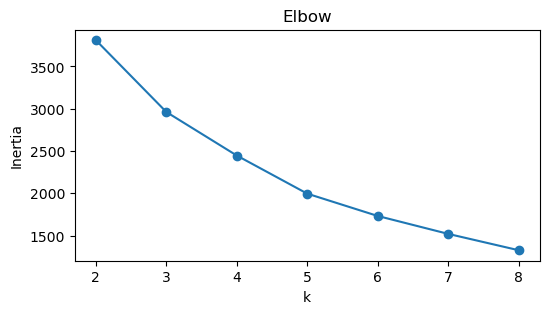

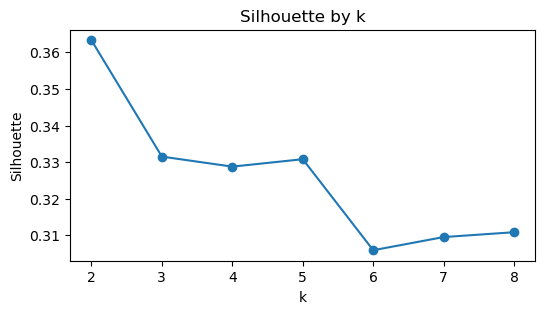

   k  silhouette
0  2    0.363316
1  3    0.331519
2  4    0.328780
3  5    0.330808
4  6    0.305939
5  7    0.309533
6  8    0.310857


In [83]:
plt.figure(figsize=(6,3))
plt.plot(ks, inertias, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow")
plt.show()

plt.figure(figsize=(6,3))
plt.plot(ks, sils, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette by k")
plt.show()

sil_df = pd.DataFrame({
    "k": ks,
    "silhouette": sils
})
print(sil_df)

In [84]:
km = KMeans(n_clusters=5, n_init=50, random_state=0)
labels = km.fit_predict(Xz)

clusters_df = pca.copy()
clusters_df["cluster"] = labels
clusters_df["cluster"].value_counts().sort_index()

cluster
0    574
1    513
2    330
3    287
4    354
Name: count, dtype: int64

In [85]:
clusters_df["cluster"] = labels
cluster_means = clusters_df.groupby("cluster")[X.columns].mean().round(2)
print(cluster_means)

         long_PC1_relative  short_PC1_relative  arg_PC1_relative  \
cluster                                                            
0                    -0.88               -0.55              0.58   
1                     0.86                0.56             -0.46   
2                    -0.62                0.54              0.80   
3                     0.91               -1.04              0.07   
4                     0.15                0.38             -1.15   

         putt_PC1_relative  
cluster                     
0                     0.85  
1                    -0.97  
2                    -0.72  
3                     0.06  
4                     0.62  


In [86]:
clusters_df

,player,year,ott_PC1,long_PC1,short_PC1,arg_PC1,putt_PC1,long_PC1_scaled,short_PC1_scaled,arg_PC1_scaled,putt_PC1_scaled,long_PC1_relative,short_PC1_relative,arg_PC1_relative,putt_PC1_relative,cluster
0,Aaron Baddeley,2015,-1.245403,-1.365358,-1.944796,2.057671,2.445307,-0.772213,-1.190647,1.083946,1.553688,-0.695601,-1.004944,0.676635,1.023910,0
1,Adam Hadwin,2015,1.280056,0.697110,-0.682807,-0.590203,0.265212,0.394268,-0.418029,-0.310909,0.168509,1.127317,-0.973874,-0.696784,0.543340,3
2,Adam Scott,2015,-1.119878,-0.719802,0.493721,-2.054937,-3.067988,-0.407102,0.302267,-1.082506,-1.949324,0.392469,1.130820,-0.310528,-1.212760,1
3,Alex Cejka,2015,1.418699,0.323083,1.084762,0.338617,-0.653147,0.182728,0.664115,0.178378,-0.414994,0.068302,1.158073,0.058454,-1.284829,1
4,Alex Prugh,2015,0.289179,0.776559,1.524262,-3.034307,-2.297580,0.439203,0.933186,-1.598422,-1.459826,0.664069,1.045214,-0.908110,-0.801173,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,Will Gordon,2025,-2.092310,2.312327,-1.200163,-1.699310,-3.004905,1.307796,-0.734766,-0.895168,-1.909243,1.383922,-0.131239,-0.250224,-1.002459,1
2054,William Mouw,2025,-0.983369,1.238207,-1.306314,-0.058132,-0.128105,0.700300,-0.799754,-0.030623,-0.081395,1.229149,-1.218896,0.036303,-0.046555,3
2055,Wyndham Clark,2025,-1.935702,-0.264714,-1.124078,0.386748,1.915548,-0.149716,-0.688185,0.203732,1.217092,-0.367980,-1.038646,0.072241,1.334386,0
2056,Xander Schauffele,2025,-1.845975,1.345282,0.083933,-0.873734,-1.159236,0.760859,0.051386,-0.460269,-0.736550,1.302418,0.224206,-0.553374,-0.973250,1


In [87]:
clusters_df[clusters_df.player.isin(['Collin Morikawa', 'Xander Schauffele', 'Rory McIlroy', 'Scottie Scheffler']) & (clusters_df.year == 2025)]

,player,year,ott_PC1,long_PC1,short_PC1,arg_PC1,putt_PC1,long_PC1_scaled,short_PC1_scaled,arg_PC1_scaled,putt_PC1_scaled,long_PC1_relative,short_PC1_relative,arg_PC1_relative,putt_PC1_relative,cluster
1918,Collin Morikawa,2025,1.244774,2.296827,3.362508,0.612424,-0.720225,1.299030,2.058600,0.322614,-0.457614,0.447752,1.137088,-0.438378,-1.146462,1
2014,Rory McIlroy,2025,-3.272431,1.461952,-0.016325,2.018276,2.073139,0.826844,-0.009995,1.063194,1.317222,0.047834,-1.406276,0.458519,0.899923,0
2025,Scottie Scheffler,2025,-0.549861,3.866101,3.733631,5.267945,2.926947,2.186573,2.285810,2.775064,1.859711,-0.238167,0.023813,1.315427,-1.101073,2
2056,Xander Schauffele,2025,-1.845975,1.345282,0.083933,-0.873734,-1.159236,0.760859,0.051386,-0.460269,-0.736550,1.302418,0.224206,-0.553374,-0.973250,1


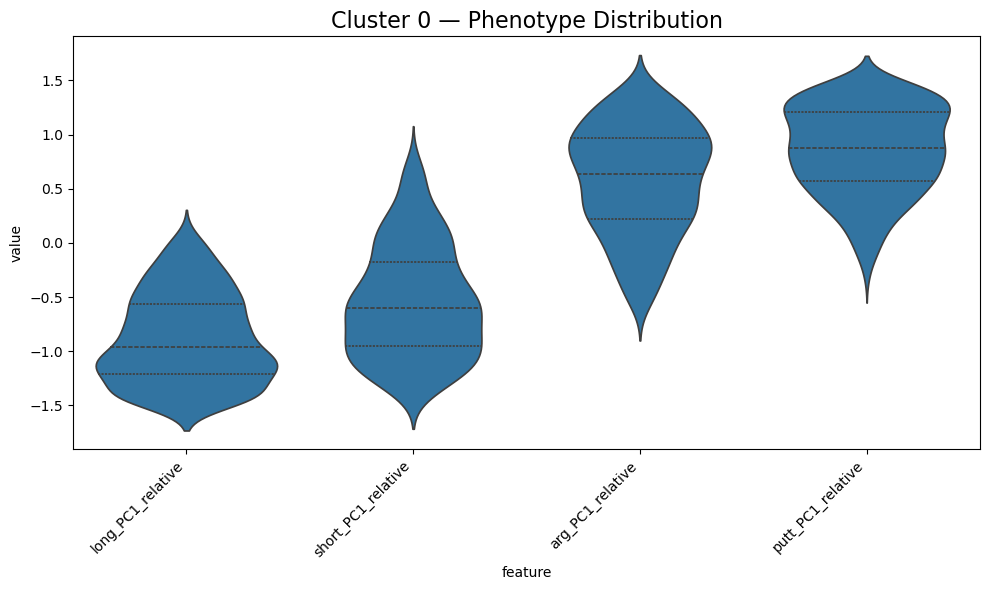

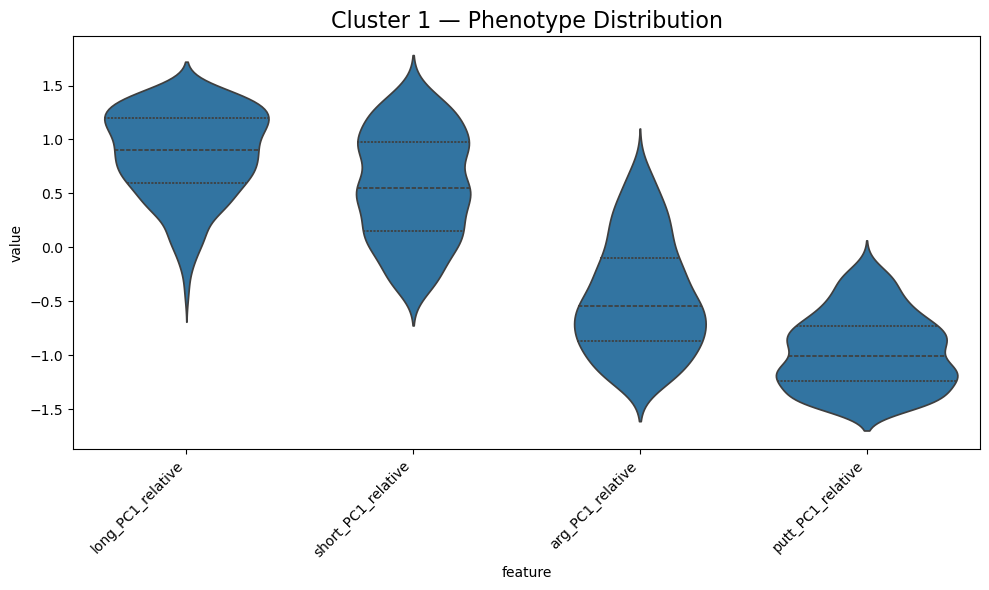

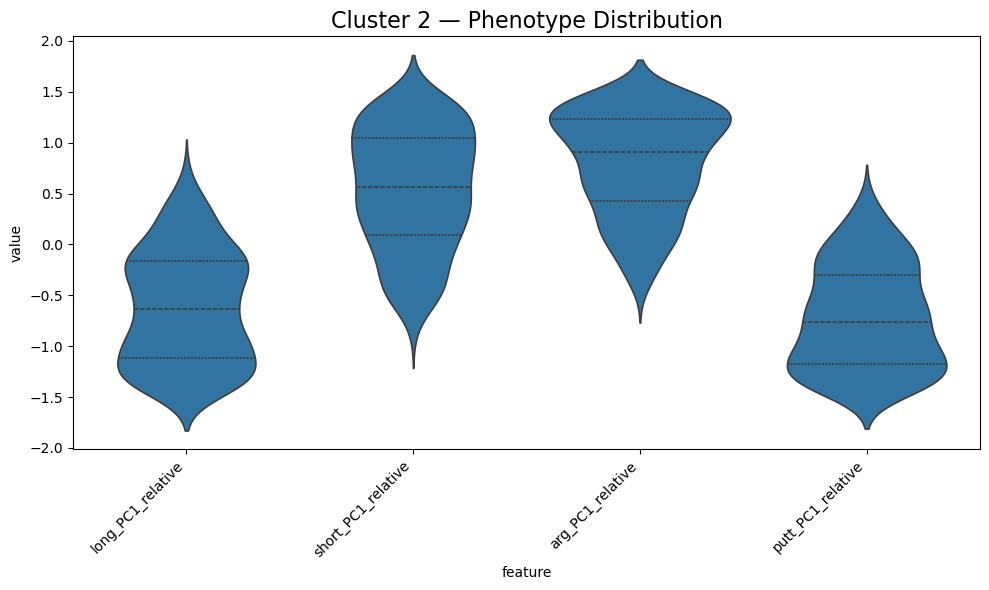

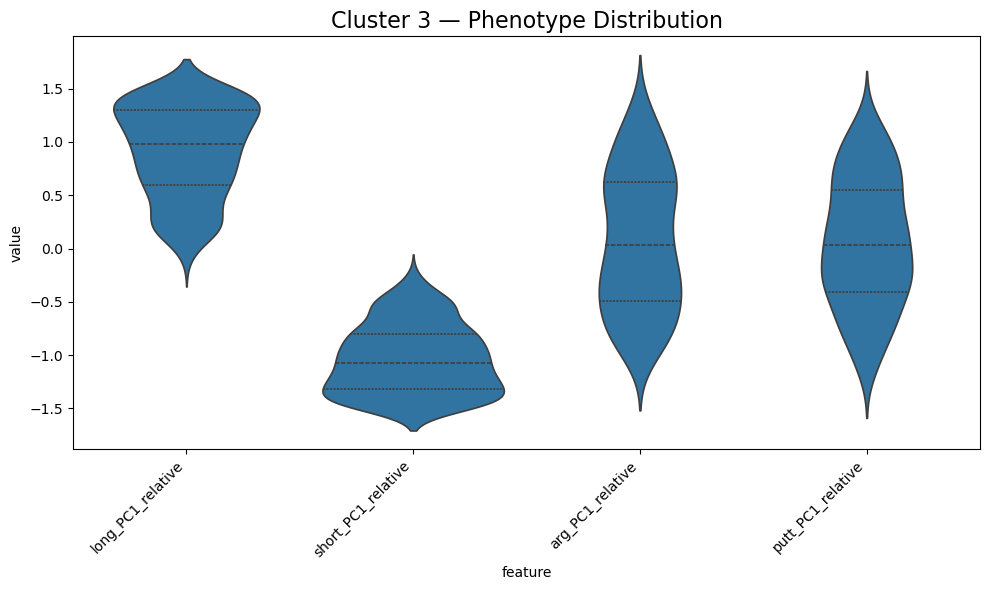

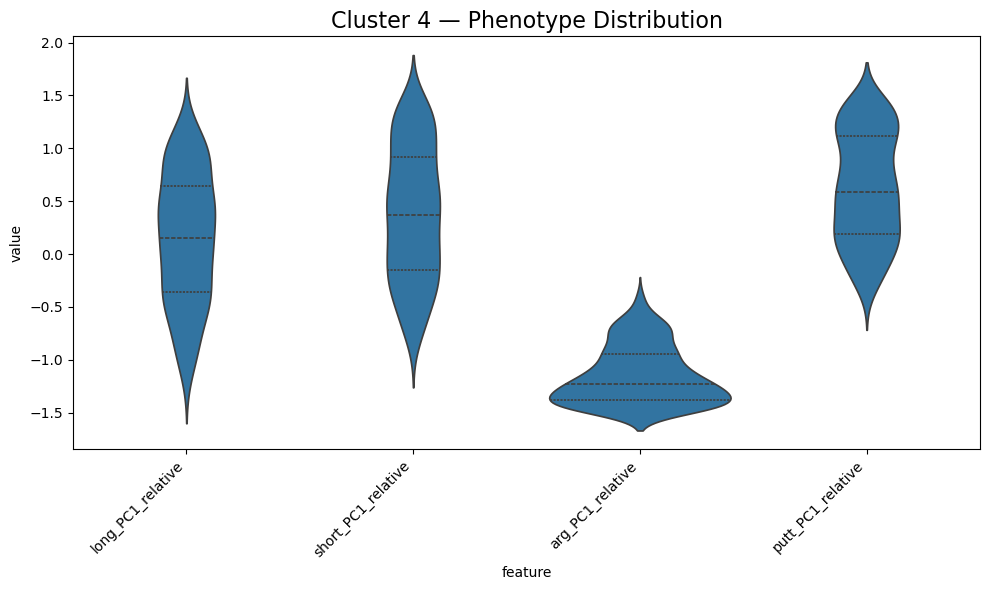

In [88]:
features = [col for col in clusters_df.columns if col.endswith("relative")]

clusters = sorted(clusters_df["cluster"].unique())

for cluster in clusters:
    subset = clusters_df[clusters_df["cluster"] == cluster]
    
    plt.figure(figsize=(10, 6))
    sns.violinplot(
        data=subset[features].melt(var_name="feature", value_name="value"),
        x="feature",
        y="value",
        inner="quartile"
    )
    
    plt.title(f"Cluster {cluster} — Phenotype Distribution", fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [89]:
clusters_df.head()

,player,year,ott_PC1,long_PC1,short_PC1,arg_PC1,putt_PC1,long_PC1_scaled,short_PC1_scaled,arg_PC1_scaled,putt_PC1_scaled,long_PC1_relative,short_PC1_relative,arg_PC1_relative,putt_PC1_relative,cluster
0,Aaron Baddeley,2015,-1.245403,-1.365358,-1.944796,2.057671,2.445307,-0.772213,-1.190647,1.083946,1.553688,-0.695601,-1.004944,0.676635,1.023910,0
1,Adam Hadwin,2015,1.280056,0.697110,-0.682807,-0.590203,0.265212,0.394268,-0.418029,-0.310909,0.168509,1.127317,-0.973874,-0.696784,0.543340,3
2,Adam Scott,2015,-1.119878,-0.719802,0.493721,-2.054937,-3.067988,-0.407102,0.302267,-1.082506,-1.949324,0.392469,1.130820,-0.310528,-1.212760,1
3,Alex Cejka,2015,1.418699,0.323083,1.084762,0.338617,-0.653147,0.182728,0.664115,0.178378,-0.414994,0.068302,1.158073,0.058454,-1.284829,1
4,Alex Prugh,2015,0.289179,0.776559,1.524262,-3.034307,-2.297580,0.439203,0.933186,-1.598422,-1.459826,0.664069,1.045214,-0.908110,-0.801173,1


In [90]:
clusters_df.rename(columns={"long_PC1_relative": "Long Iron Game", "short_PC1_relative": "Short Iron Game", "arg_PC1_relative": "Around-the-Green", "putt_PC1_relative": "Putting"}, inplace=True)

/var/folders/94/k_n9_k290dq3fhrtlyvj38qh0000gn/T/ipykernel_47909/694698705.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


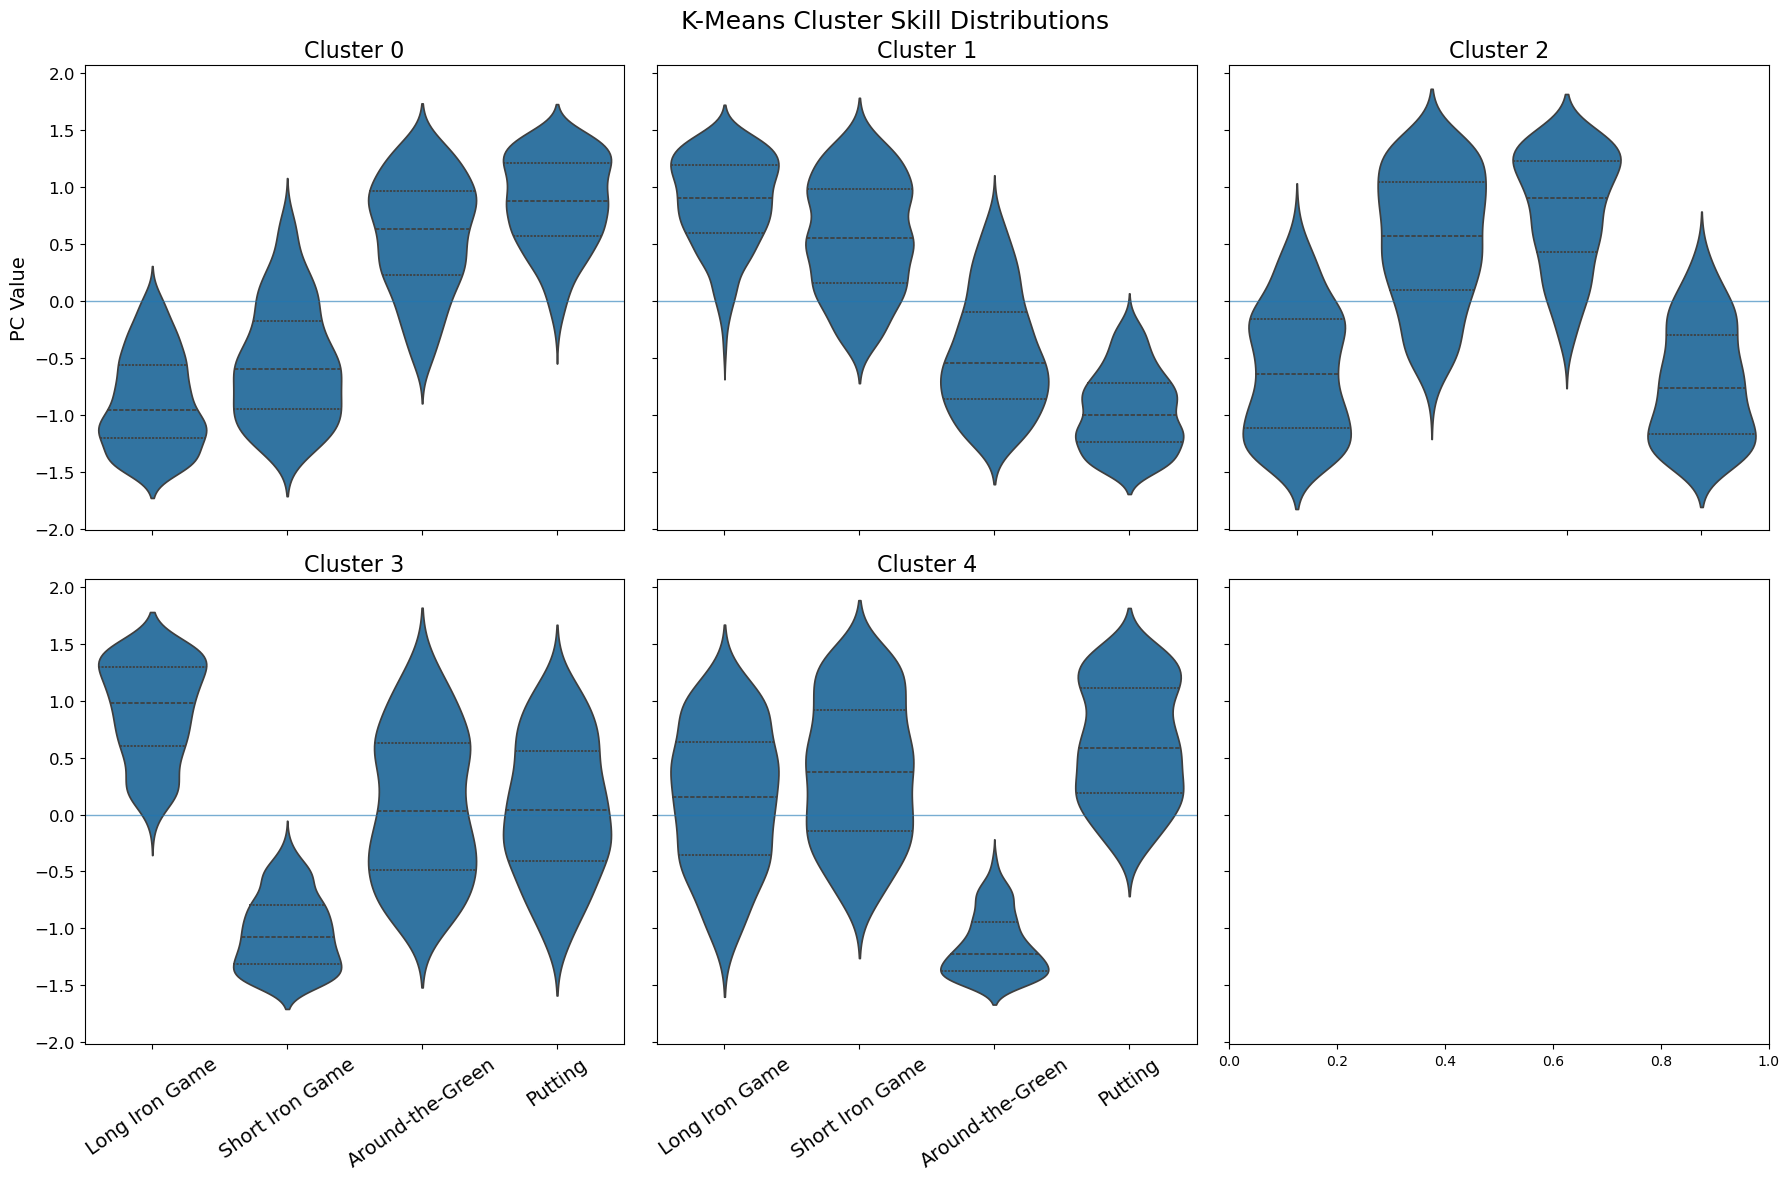

In [91]:
features = [col for col in clusters_df.columns if not "PC" in col and col not in ["player", "year", "cluster"]]
clusters = sorted(clusters_df["cluster"].unique())

fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True, constrained_layout=True)
axes = axes.flatten()

# example code for plotting violin plot was obtained by ChatGPT and modified for this case
# Prompt: "Give me pseudocode for plotting violin plots of multiple features across different clusters using seaborn in python"
for i, (ax, cluster) in enumerate(zip(axes, clusters)):
    subset = clusters_df[clusters_df["cluster"] == cluster]

    melted = subset[features].melt(
        var_name="feature",
        value_name="value"
    )

    sns.violinplot(
        data=melted,
        x="feature",
        y="value",
        inner="quartile",
        legend=False,
        ax=ax,
        order=features,
        density_norm="width",
    )
    
    ax.axhline(0, lw=1, alpha=0.6)

    ax.set_title(f"Cluster {cluster}", fontsize=16)
    ax.tick_params(axis="y", labelsize=12)
    
    # Set y-axis label only for left column plots and x-axis labels only for bottom row plots
    if i % 2 == 0:
        ax.set_ylabel("PC Value", fontsize=14)
    else:
        ax.set_ylabel("")
        
    if i >= 3:
        ax.set_xlabel("")
        ax.tick_params(axis="x", rotation=35, labelsize=14)
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    
    

fig.suptitle("K-Means Cluster Skill Distributions", fontsize=18)

plt.tight_layout()
plt.show()


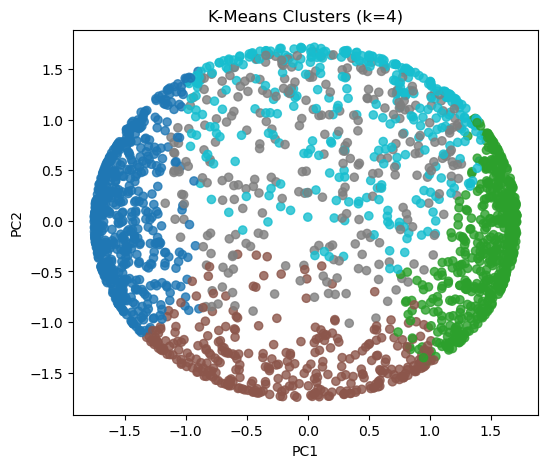

In [92]:
from sklearn.decomposition import PCA

viz_pca = PCA(n_components=2)
viz_2d = viz_pca.fit_transform(Xz)

plt.figure(figsize=(6,5))
plt.scatter(
    viz_2d[:,0], viz_2d[:,1],
    c=labels,
    cmap="tab10",
    s=35,
    alpha=0.8,
)
plt.title(f"K-Means Clusters (k=4)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [93]:
clusters_df["cluster"].value_counts().sort_index()

cluster
0    574
1    513
2    330
3    287
4    354
Name: count, dtype: int64

## Gaussian Mixture Models

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

cov_types = ["full", "tied", "diag", "spherical"]

plt.figure(figsize=(7,5))

all_sils = {}

for cov in cov_types:
    sils = []
    for k in range(2, 10):
        gmm = GaussianMixture(
            n_components=k,
            covariance_type=cov,
            n_init=50,
            max_iter=5000,
            init_params="kmeans",
            reg_covar=1e-3,
            random_state=0
        )
        labels = gmm.fit_predict(Xz)
        sils.append(silhouette_score(Xz, labels))
    all_sils[cov] = sils
    plt.plot(range(2,10), sils, marker='o', label=cov)

plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("GMM Silhouette Scores by Covariance Type")
plt.legend()
plt.show()

for cov, sils in all_sils.items():
    print(f"\n{cov} covariance:")
    for k, s in zip(range(2,10), sils):
        print(f"  k={k}: silhouette={s:.4f}")

In [ ]:
best_cov = "full"
best_k = 5

gmm = GaussianMixture(
    n_components=best_k,
    covariance_type=best_cov,
    n_init=50,
    max_iter=5000,
    init_params="kmeans",
    random_state=0
)

gmm_labels = gmm.fit_predict(Xz)

In [ ]:
gmm_clusters_df = pca.copy()
gmm_clusters_df["gmm_cluster"] = gmm_labels

In [ ]:
print(gmm_clusters_df["gmm_cluster"].value_counts().sort_index())

cluster_means = gmm_clusters_df.groupby("gmm_cluster")[X.columns].mean().round(2)
print(cluster_means)


gmm_cluster
0    369
1    401
2    509
3    447
4    332
Name: count, dtype: int64
             long_PC1_relative  short_PC1_relative  arg_PC1_relative  \
gmm_cluster                                                            
0                        -0.65                0.62              0.69   
1                         0.14                0.27             -1.09   
2                        -0.90               -0.58              0.63   
3                         0.88                0.60             -0.53   
4                         0.87               -0.96              0.22   

             putt_PC1_relative  
gmm_cluster                     
0                        -0.67  
1                         0.69  
2                         0.86  
3                        -0.96  
4                        -0.13  


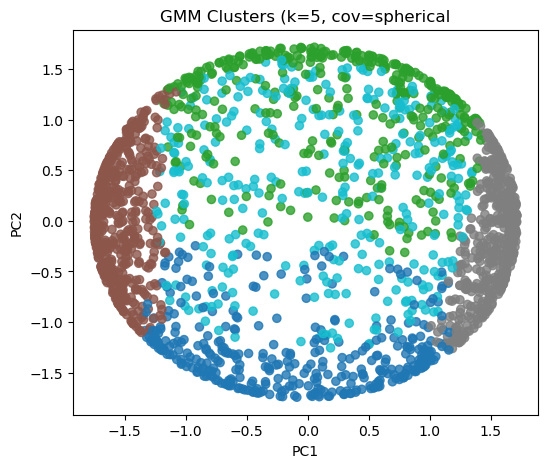

In [ ]:
from sklearn.decomposition import PCA

viz_pca = PCA(n_components=2)
viz_2d = viz_pca.fit_transform(Xz)

plt.figure(figsize=(6,5))
plt.scatter(
    viz_2d[:,0], viz_2d[:,1],
    c=gmm_labels,
    cmap="tab10",
    s=35,
    alpha=0.8
)
plt.title(f"GMM Clusters (k={best_k}, cov=spherical")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
gmm_clusters_df.head()

,player,year,ott_PC1,long_PC1,short_PC1,arg_PC1,putt_PC1,long_PC1_scaled,short_PC1_scaled,arg_PC1_scaled,putt_PC1_scaled,long_PC1_relative,short_PC1_relative,arg_PC1_relative,putt_PC1_relative,gmm_cluster
0,Aaron Baddeley,2015,-1.245403,-1.365358,-1.944796,2.057671,2.445307,-0.772213,-1.190647,1.083946,1.553688,-0.695601,-1.004944,0.676635,1.023910,2
1,Adam Hadwin,2015,1.280056,0.697110,-0.682807,-0.590203,0.265212,0.394268,-0.418029,-0.310909,0.168509,1.127317,-0.973874,-0.696784,0.543340,4
2,Adam Scott,2015,-1.119878,-0.719802,0.493721,-2.054937,-3.067988,-0.407102,0.302267,-1.082506,-1.949324,0.392469,1.130820,-0.310528,-1.212760,3
3,Alex Cejka,2015,1.418699,0.323083,1.084762,0.338617,-0.653147,0.182728,0.664115,0.178378,-0.414994,0.068302,1.158073,0.058454,-1.284829,0
4,Alex Prugh,2015,0.289179,0.776559,1.524262,-3.034307,-2.297580,0.439203,0.933186,-1.598422,-1.459826,0.664069,1.045214,-0.908110,-0.801173,3


In [ ]:
gmm_clusters_df.rename(columns={"long_PC1_relative": "Long Iron Game", "short_PC1_relative": "Short Iron Game", "arg_PC1_relative": "Around-the-Green", "putt_PC1_relative": "Putting"}, inplace=True)

/var/folders/94/k_n9_k290dq3fhrtlyvj38qh0000gn/T/ipykernel_47909/2493152491.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


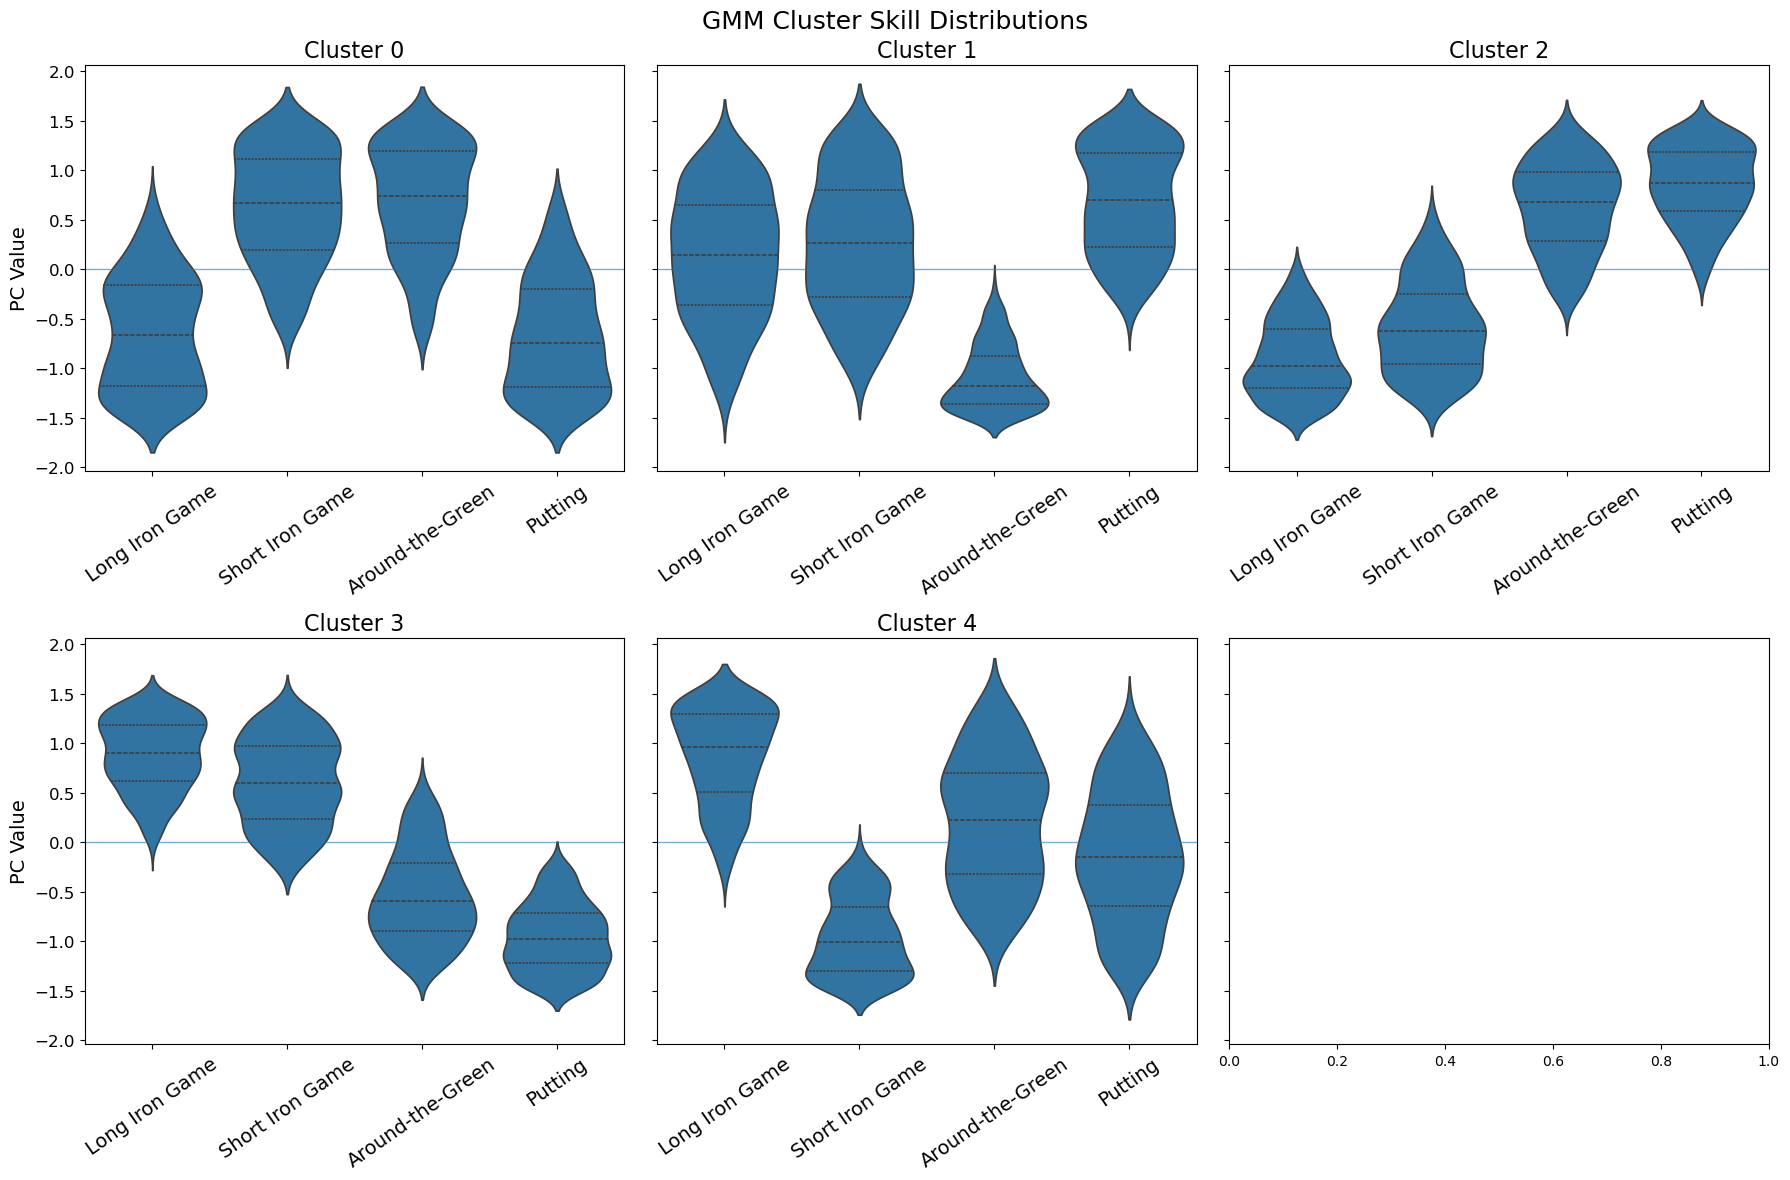

In [ ]:
features = [col for col in gmm_clusters_df.columns if not "PC" in col and col not in ["player", "year", "gmm_cluster"]]
clusters = sorted(gmm_clusters_df["gmm_cluster"].unique())

fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True, constrained_layout=True)
axes = axes.flatten()

palette = sns.color_palette("Set2", n_colors=len(features))

for ax, cluster in zip(axes, clusters):
    subset = gmm_clusters_df[gmm_clusters_df["gmm_cluster"] == cluster]

    melted = subset[features].melt(
        var_name="feature",
        value_name="value"
    )

    sns.violinplot(
        data=melted,
        x="feature",
        y="value",
        inner="quartile",
        legend=False,
        ax=ax,
        order=features,
        density_norm="width",
    )
    
    ax.axhline(0, lw=1, alpha=0.6)

    ax.set_title(f"Cluster {cluster}", fontsize=16)
    ax.tick_params(axis="y", labelsize=12)
    
    if i % 2 == 0:
        ax.set_ylabel("PC Value", fontsize=14)
    else:
        ax.set_ylabel("")
        
    if i >= 3:
        ax.set_xlabel("")
        ax.tick_params(axis="x", rotation=35, labelsize=14)
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])

fig.suptitle("GMM Cluster Skill Distributions", fontsize=18)

plt.tight_layout()
plt.show()


In [ ]:
gmm_clusters_df.head()

,player,year,ott_PC1,long_PC1,short_PC1,arg_PC1,putt_PC1,long_PC1_scaled,short_PC1_scaled,arg_PC1_scaled,putt_PC1_scaled,Long Iron Game,Short Iron Game,Around-the-Green,Putting,gmm_cluster
0,Aaron Baddeley,2015,-1.245403,-1.365358,-1.944796,2.057671,2.445307,-0.772213,-1.190647,1.083946,1.553688,-0.695601,-1.004944,0.676635,1.023910,2
1,Adam Hadwin,2015,1.280056,0.697110,-0.682807,-0.590203,0.265212,0.394268,-0.418029,-0.310909,0.168509,1.127317,-0.973874,-0.696784,0.543340,4
2,Adam Scott,2015,-1.119878,-0.719802,0.493721,-2.054937,-3.067988,-0.407102,0.302267,-1.082506,-1.949324,0.392469,1.130820,-0.310528,-1.212760,3
3,Alex Cejka,2015,1.418699,0.323083,1.084762,0.338617,-0.653147,0.182728,0.664115,0.178378,-0.414994,0.068302,1.158073,0.058454,-1.284829,0
4,Alex Prugh,2015,0.289179,0.776559,1.524262,-3.034307,-2.297580,0.439203,0.933186,-1.598422,-1.459826,0.664069,1.045214,-0.908110,-0.801173,3


In [ ]:
clusters_df.head()

,player,year,ott_PC1,long_PC1,short_PC1,arg_PC1,putt_PC1,long_PC1_scaled,short_PC1_scaled,arg_PC1_scaled,putt_PC1_scaled,Long Iron Game,Short Iron Game,Around-the-Green,Putting,cluster
0,Aaron Baddeley,2015,-1.245403,-1.365358,-1.944796,2.057671,2.445307,-0.772213,-1.190647,1.083946,1.553688,-0.695601,-1.004944,0.676635,1.023910,0
1,Adam Hadwin,2015,1.280056,0.697110,-0.682807,-0.590203,0.265212,0.394268,-0.418029,-0.310909,0.168509,1.127317,-0.973874,-0.696784,0.543340,3
2,Adam Scott,2015,-1.119878,-0.719802,0.493721,-2.054937,-3.067988,-0.407102,0.302267,-1.082506,-1.949324,0.392469,1.130820,-0.310528,-1.212760,1
3,Alex Cejka,2015,1.418699,0.323083,1.084762,0.338617,-0.653147,0.182728,0.664115,0.178378,-0.414994,0.068302,1.158073,0.058454,-1.284829,1
4,Alex Prugh,2015,0.289179,0.776559,1.524262,-3.034307,-2.297580,0.439203,0.933186,-1.598422,-1.459826,0.664069,1.045214,-0.908110,-0.801173,1


In [ ]:
gmm_clusters_df.to_csv("gmm_clusters.csv", index=False)
clusters_df.to_csv("kmeans_clusters.csv", index=False)

In [ ]:
gmm_clusters_df[gmm_clusters_df.player.isin(['Collin Morikawa', 'Xander Schauffele', 'Rory McIlroy', 'Scottie Scheffler']) & (gmm_clusters_df.year == 2025)]

,player,year,ott_PC1,long_PC1,short_PC1,arg_PC1,putt_PC1,long_PC1_scaled,short_PC1_scaled,arg_PC1_scaled,putt_PC1_scaled,Long Iron Game,Short Iron Game,Around-the-Green,Putting,gmm_cluster
1918,Collin Morikawa,2025,1.244774,2.296827,3.362508,0.612424,-0.720225,1.299030,2.058600,0.322614,-0.457614,0.447752,1.137088,-0.438378,-1.146462,3
2014,Rory McIlroy,2025,-3.272431,1.461952,-0.016325,2.018276,2.073139,0.826844,-0.009995,1.063194,1.317222,0.047834,-1.406276,0.458519,0.899923,4
2025,Scottie Scheffler,2025,-0.549861,3.866101,3.733631,5.267945,2.926947,2.186573,2.285810,2.775064,1.859711,-0.238167,0.023813,1.315427,-1.101073,0
2056,Xander Schauffele,2025,-1.845975,1.345282,0.083933,-0.873734,-1.159236,0.760859,0.051386,-0.460269,-0.736550,1.302418,0.224206,-0.553374,-0.973250,3


In [ ]:
gmm_clusters_df["gmm_cluster"].value_counts().sort_index()

gmm_cluster
0    369
1    401
2    509
3    447
4    332
Name: count, dtype: int64

In [ ]:
years = (
    gmm_clusters_df
    .groupby(["year", "gmm_cluster"])
    .size()
    .reset_index(name="n")
)